In [2]:
%matplotlib inline
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import datetime
from datetime import timedelta
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (30, 15)
# mpl.rcParams['axes.grid'] = False

target="close"

In [3]:
def getDataset(full=False):
    url = "../datasets/DAT_ASCII_EURUSD_M1_2018.csv"
    df = pd.read_csv(url, names=list(["date","open", "high", "low", "close", "volume"]), header=None, sep=";")
    # df.drop(columns=['open', 'high', 'low'], inplace=True)
    pdlen=len(df)
    
    df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
    # df.set_axis(df['date'], inplace=True)
    # df.drop(columns=["volume"], inplace=True)
    df.drop(columns=["volume", "low", "open", "high"], inplace=True)
    # df["Close"]= df["close"] # compatibility
    # df["Volume"]= df["volume"] # compatibility
    # df.drop(columns=['close'], inplace=True)
    # df["ewma_close"]=df["close"].ewm(4).mean()
    if full is False:
        df=df[58::60]
        
    return df

In [4]:
df = getDataset(full=False)
df
# df.set_axis(df['date'])[target].plot(figsize=(15,8))
# plt.legend(["close"])
# plt.grid(True)
# plt.title("Wykres przedstawiający wartość stosunku ceny euro do dolara amerykańskiego w roku 2018")
# plt.xlabel("Data")
# plt.ylabel("Wartość stosunku euro do dolara")

,date,close
58,2018-01-01 17:59:00,1.20136
118,2018-01-01 18:59:00,1.20107
178,2018-01-01 19:59:00,1.20161
238,2018-01-01 20:59:00,1.20154
298,2018-01-01 21:59:00,1.20092
...,...,...
372358,2018-12-31 12:51:00,1.14462
372418,2018-12-31 13:51:00,1.14454
372478,2018-12-31 14:51:00,1.14529
372538,2018-12-31 15:51:00,1.14596


In [5]:
date_time = pd.to_datetime(df.pop('date'))
# print(date_time)

In [6]:
# adjusted_date_time = []
# print([date_time.values[0]+timedelta(minutes=(i-1)*1) for i in range(len(date_time.values))])


date_time_clone = date_time.copy()
new_values=pd.date_range(date_time.values[0], periods=len(date_time), freq='1h')

i=0
for key in date_time_clone.copy().keys():
    date_time_clone[key]=new_values[i]
    i=i+1

date_time=date_time_clone
print(date_time)

58       2018-01-01 17:59:00
118      2018-01-01 18:59:00
178      2018-01-01 19:59:00
238      2018-01-01 20:59:00
298      2018-01-01 21:59:00
                 ...        
372358   2018-09-17 06:59:00
372418   2018-09-17 07:59:00
372478   2018-09-17 08:59:00
372538   2018-09-17 09:59:00
372598   2018-09-17 10:59:00
Name: date, Length: 6210, dtype: datetime64[ns]


In [7]:
timestamp_s = date_time.map(datetime.datetime.timestamp)
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

timestamp_s[:5]

58     1.514826e+09
118    1.514830e+09
178    1.514833e+09
238    1.514837e+09
298    1.514840e+09
Name: date, dtype: float64

In [8]:
mpl.rcParams['figure.figsize'] = (20, 12)

In [9]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [10]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [11]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [12]:
def plotLossHistory(history):
    fig, ax = plt.subplots(figsize=(30,15))
    ax.plot(history.history['loss'], label='Wartość funkcji kosztu dla zbioru treningowego')
    ax.plot(history.history['val_loss'], label='Wartość funkcji kosztu dla zbioru walidacyjnego')
    plt.ylabel('Wartość funkcji kosztu')
    plt.xlabel('Numer epoki')
    ax.legend(loc="upper left")
    plt.title("Wartość funkcji kosztu na przestrzeni epok")
    plt.show()

In [13]:
def plotMAEHistory(history):
    fig, ax = plt.subplots(figsize=(30,15))
    ax.plot(history.history['mean_absolute_error'], label='MAE podczas treningu')
    ax.plot(history.history['val_mean_absolute_error'], label='MAE na zbiorze walidacyjnym')
    plt.ylabel('MAE value')
    plt.xlabel('Numer epoki')
    ax.legend(loc="upper left")
    plt.show()

In [14]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [15]:
val_performance_single = {}
performance_single = {}

In [16]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [17]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [18]:
def plot(self, model=None, plot_col=target, max_subplots=3, title=None, figsize=(15,15)):
  inputs, labels = self.example
  plt.figure(figsize=figsize)
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)

    if title is not None and n==0:
      plt.title(title)

    plt.xticks(np.arange(0, len(self.input_indices)+1, step=1))
    
    plt.ylabel(f'{plot_col} [znormalizowana wartość]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Wejście', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Prawdziwe wartości', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
  
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predykcje',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Czas od pierwszej próbki [h]')

WindowGenerator.plot = plot

In [19]:
def show_example(self):
    inputs, labels = self.example
    print(inputs)

WindowGenerator.show_example = show_example

In [20]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=[target])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['close']

In [21]:
# print(wide_window.show_example())
# print(wide_window.show_example())

In [22]:
MAX_EPOCHS = 50

def compile_and_fit(model, window, patience=50):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [23]:
mpl.rcParams['figure.figsize'] = (15, 8)

In [24]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.GRU(40, return_sequences=True),
    # tf.keras.layers.LSTM(10, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [25]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 5)
Output shape: (32, 24, 1)


In [26]:
%%time
history = compile_and_fit(lstm_model, wide_window)

Epoch 1/50
136/136 [==============================] - 2s 12ms/step - loss: 0.1995 - mean_absolute_error: 0.2854 - val_loss: 0.1095 - val_mean_absolute_error: 0.2357
Epoch 2/50
136/136 [==============================] - 1s 10ms/step - loss: 0.0229 - mean_absolute_error: 0.0768 - val_loss: 0.0399 - val_mean_absolute_error: 0.1205
Epoch 3/50
136/136 [==============================] - 1s 10ms/step - loss: 0.0129 - mean_absolute_error: 0.0580 - val_loss: 0.0237 - val_mean_absolute_error: 0.0915
Epoch 4/50
136/136 [==============================] - 1s 9ms/step - loss: 0.0080 - mean_absolute_error: 0.0471 - val_loss: 0.0172 - val_mean_absolute_error: 0.0834
Epoch 5/50
136/136 [==============================] - 1s 9ms/step - loss: 0.0053 - mean_absolute_error: 0.0405 - val_loss: 0.0134 - val_mean_absolute_error: 0.0743
Epoch 6/50
136/136 [==============================] - 1s 9ms/step - loss: 0.0037 - mean_absolute_error: 0.0363 - val_loss: 0.0115 - val_mean_absolute_error: 0.0694
Epoch 7/50
13

In [27]:
val_performance_single['LSTM'] = lstm_model.evaluate(wide_window.val)
performance_single['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

39/39 [==============================] - 0s 2ms/step - loss: 0.0014 - mean_absolute_error: 0.0274


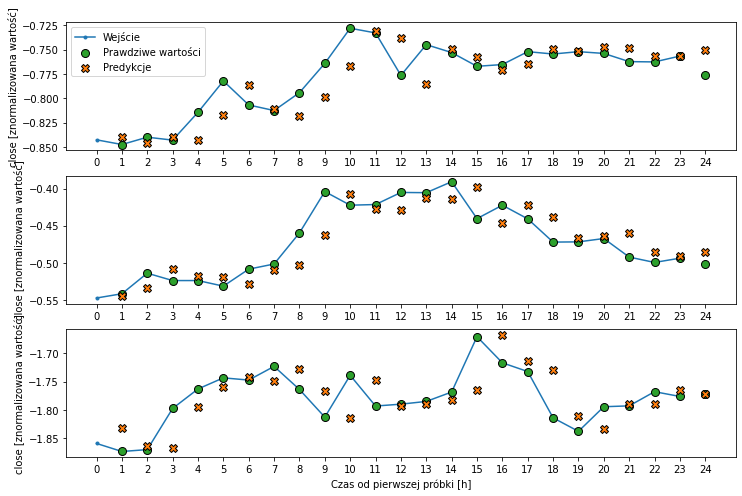

In [28]:
wide_window.plot(lstm_model, figsize=(12,8))

In [29]:
gru_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.GRU(24, return_sequences=True),
    tf.keras.layers.GRU(24, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [30]:
%%time
history = compile_and_fit(gru_model, wide_window)


Epoch 1/50
136/136 [==============================] - 2s 16ms/step - loss: 0.1280 - mean_absolute_error: 0.2318 - val_loss: 0.1355 - val_mean_absolute_error: 0.2833
Epoch 2/50
136/136 [==============================] - 2s 15ms/step - loss: 0.0224 - mean_absolute_error: 0.0806 - val_loss: 0.0379 - val_mean_absolute_error: 0.1356
Epoch 3/50
136/136 [==============================] - 2s 16ms/step - loss: 0.0101 - mean_absolute_error: 0.0553 - val_loss: 0.0198 - val_mean_absolute_error: 0.0997
Epoch 4/50
136/136 [==============================] - 2s 17ms/step - loss: 0.0050 - mean_absolute_error: 0.0422 - val_loss: 0.0142 - val_mean_absolute_error: 0.0873
Epoch 5/50
136/136 [==============================] - 2s 18ms/step - loss: 0.0029 - mean_absolute_error: 0.0353 - val_loss: 0.0108 - val_mean_absolute_error: 0.0754
Epoch 6/50
136/136 [==============================] - 2s 17ms/step - loss: 0.0021 - mean_absolute_error: 0.0314 - val_loss: 0.0100 - val_mean_absolute_error: 0.0724
Epoch 7/50

In [31]:

IPython.display.clear_output()
val_performance_single['GRU'] = gru_model.evaluate(wide_window.val)
performance_single['GRU'] = gru_model.evaluate(wide_window.test, verbose=0)

39/39 [==============================] - 0s 4ms/step - loss: 0.0072 - mean_absolute_error: 0.0655


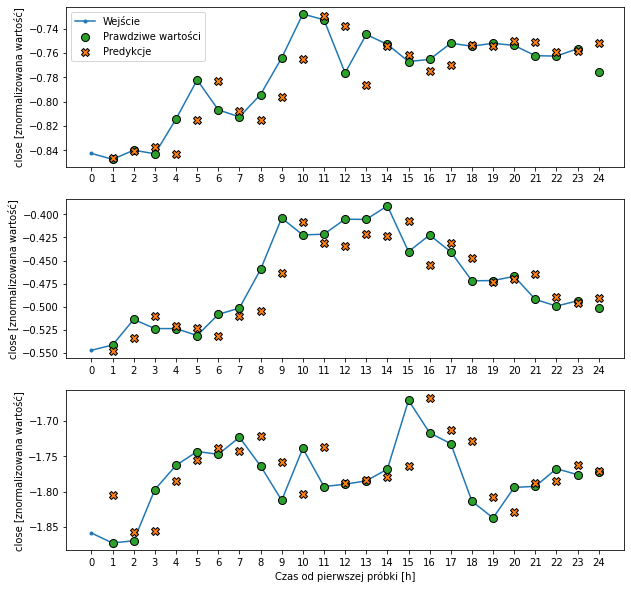

In [32]:
wide_window.plot(gru_model, figsize=(10,10))

In [33]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [37]:
baseline = Baseline(label_index=column_indices[target])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}

wide_window = WindowGenerator(input_width=24, label_width=24, shift=1, label_columns=[target])

val_performance_single['Baseline'] = baseline.evaluate(wide_window.val, verbose=1)
performance_single['Baseline'] = baseline.evaluate(wide_window.test, verbose=1)

19/19 [==============================] - 0s 1ms/step - loss: 9.3307e-04 - mean_absolute_error: 0.0210


In [109]:
lstm_model.predict(np.array([wide_window.example[0][0]]))[0].reshape(1,-1)[0]

array([-0.8135465 , -0.83346933, -0.82199854, -0.8191182 , -0.82334656,
       -0.83205956, -0.8673781 , -0.8733598 , -0.89311224, -0.8977228 ,
       -0.8870474 , -0.9350432 , -0.91086733, -0.8807587 , -0.81229687,
       -0.81413364, -0.82110226, -0.80722696, -0.8220748 , -0.79656464,
       -0.7848269 , -0.78613216, -0.7836007 , -0.77832067], dtype=float32)

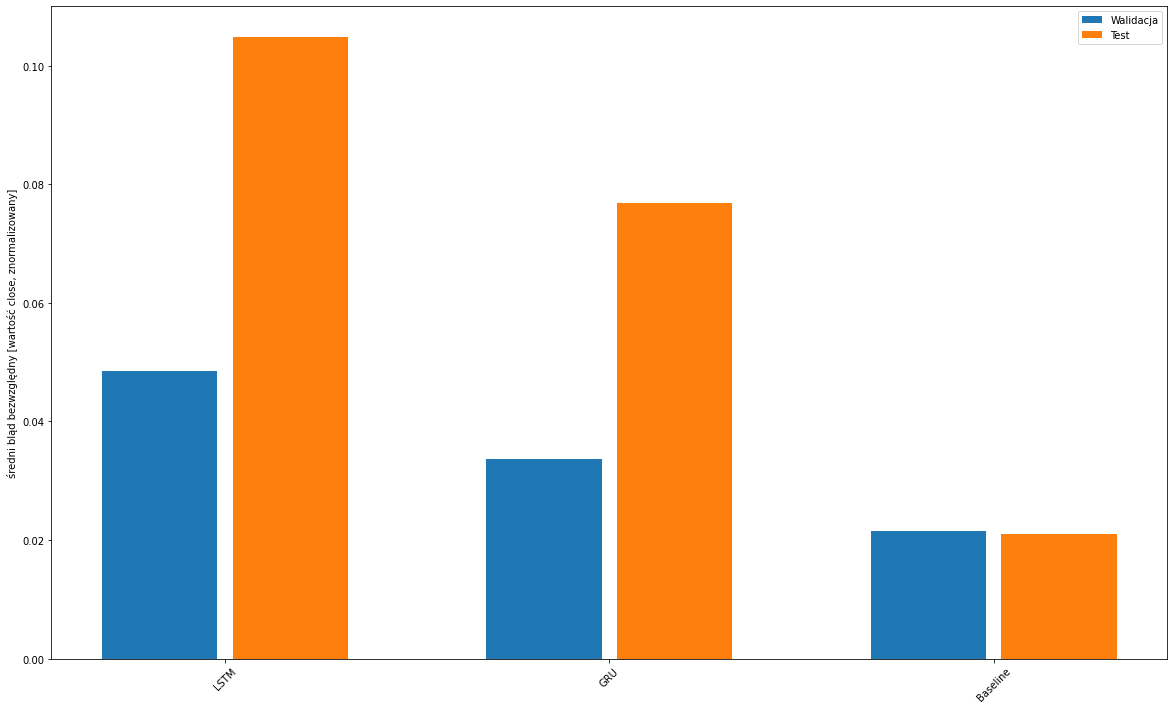

In [89]:
x = np.arange(len(performance_single))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance_single.values()]
test_mae = [v[metric_index] for v in performance_single.values()]

plt.ylabel('średni bląd bezwzględny [wartość close, znormalizowany]')
plt.bar(x - 0.17, val_mae, width, label='Walidacja')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance_single.keys(),
           rotation=45)
_ = plt.legend()

In [ ]:
performance_single

In [ ]:
for name, value in performance_single.items():
  print(f'{name:12s}: {value[1]:0.4f}')

In [40]:
%%time
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()

CPU times: user 1min 50s, sys: 36 s, total: 2min 26s
Wall time: 54.1 s


In [41]:

val_performance_single['LSTM'] = lstm_model.evaluate( wide_window.val)
performance_single['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

39/39 [==============================] - 0s 2ms/step - loss: 0.0021 - mean_absolute_error: 0.0348


In [29]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each timestep is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [30]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.GRU(50, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros)
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance_single['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance_single['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)


39/39 [==============================] - 0s 3ms/step - loss: 4.7604e-04 - mean_absolute_error: 0.0143
CPU times: user 2min 21s, sys: 45.3 s, total: 3min 6s
Wall time: 1min 3s


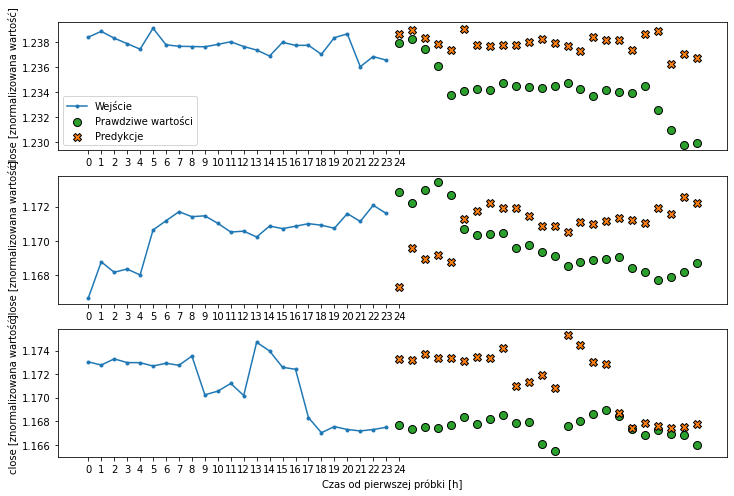

In [33]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot(residual_lstm, figsize=(12,8))                               

In [ ]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance_single.values()]
test_mae = [v[metric_index] for v in performance_single.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

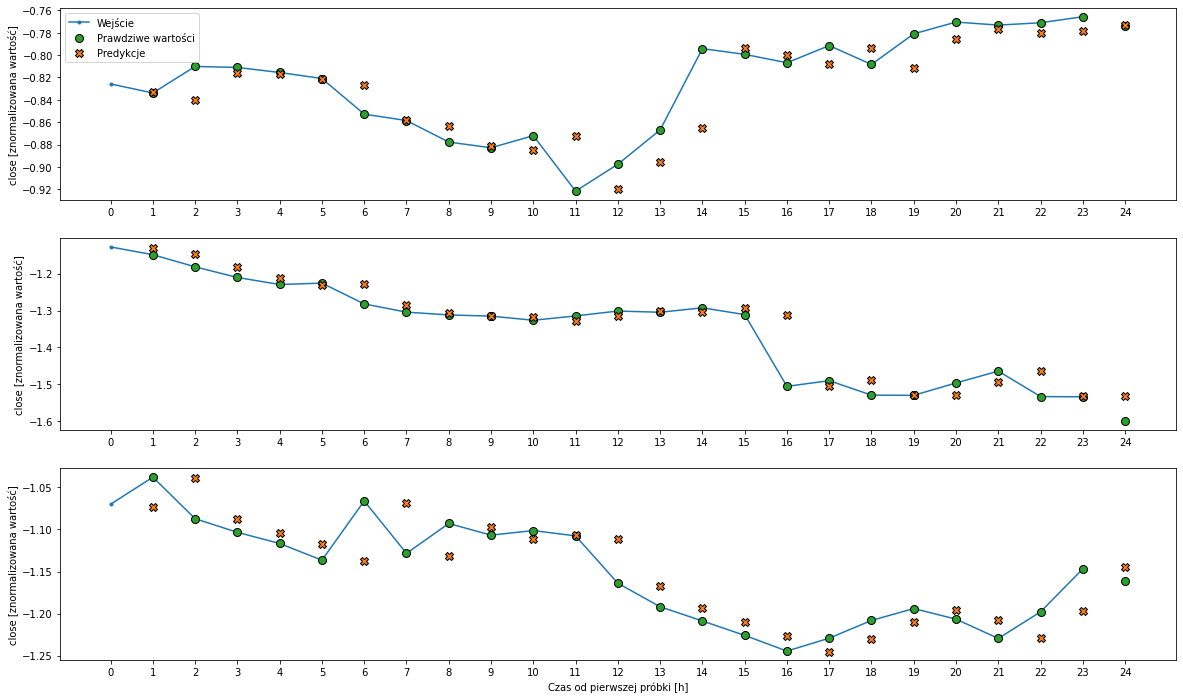

In [82]:
wide_window.plot(residual_lstm)

In [83]:
for name, value in performance_single.items():
  print(f'{name:15s}: {value[1]:0.4f}')

LSTM           : 0.1048
GRU            : 0.0769


Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

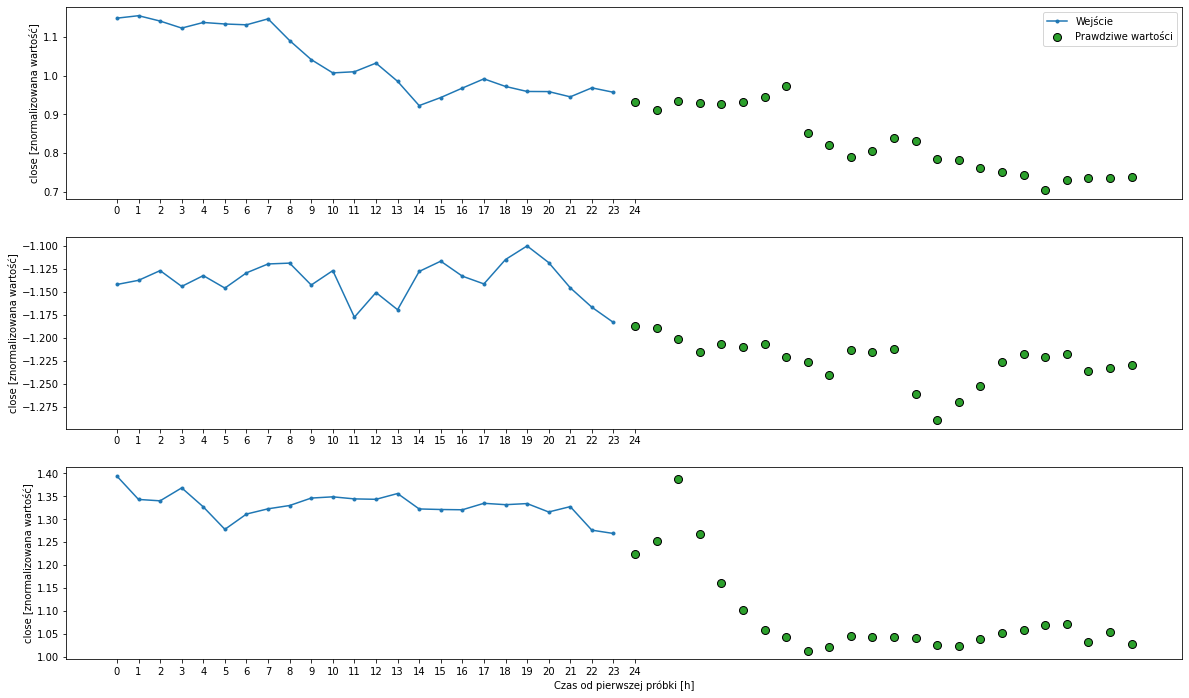

In [84]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

38/38 [==============================] - 0s 1ms/step - loss: 0.8022 - mean_absolute_error: 0.4792


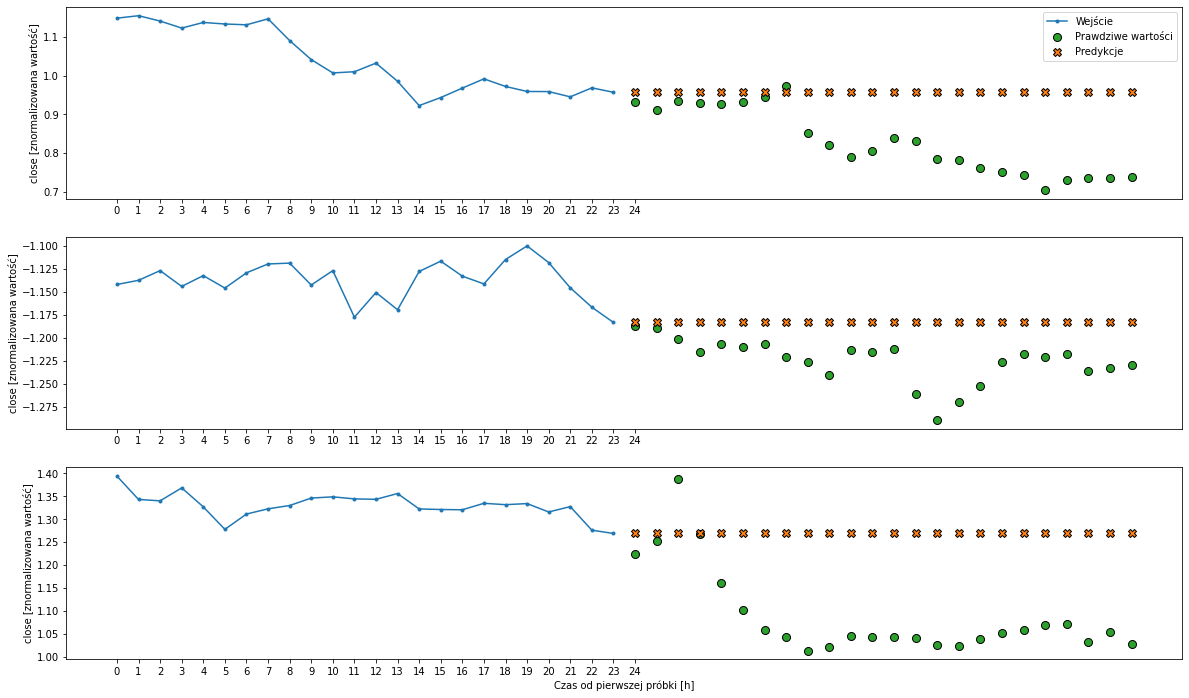

In [85]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.val, verbose=0)
multi_window.plot(last_baseline)

In [1]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

NameError: name 'tf' is not defined

In [87]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(24, return_sequences=True),
    tf.keras.layers.LSTM(24, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

38/38 [==============================] - 0s 3ms/step - loss: 0.2481 - mean_absolute_error: 0.4003


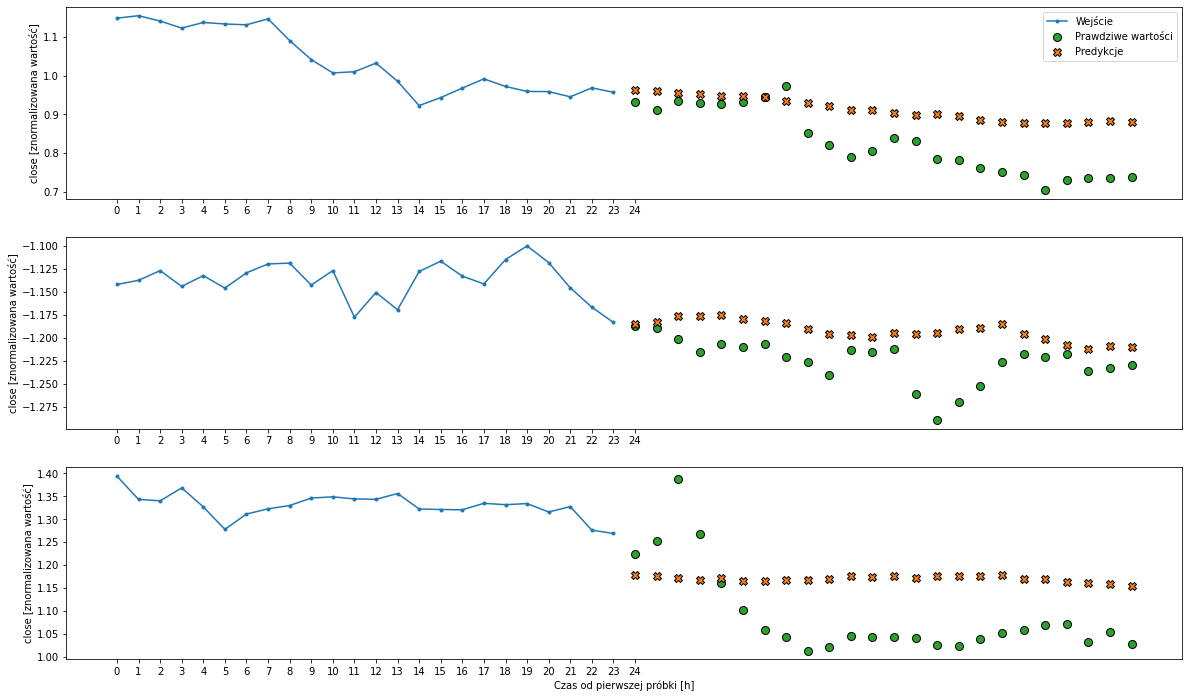

In [90]:
multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.train, verbose=0)
multi_window.plot(multi_lstm_model)

38/38 [==============================] - 0s 4ms/step - loss: 0.1338 - mean_absolute_error: 0.2543


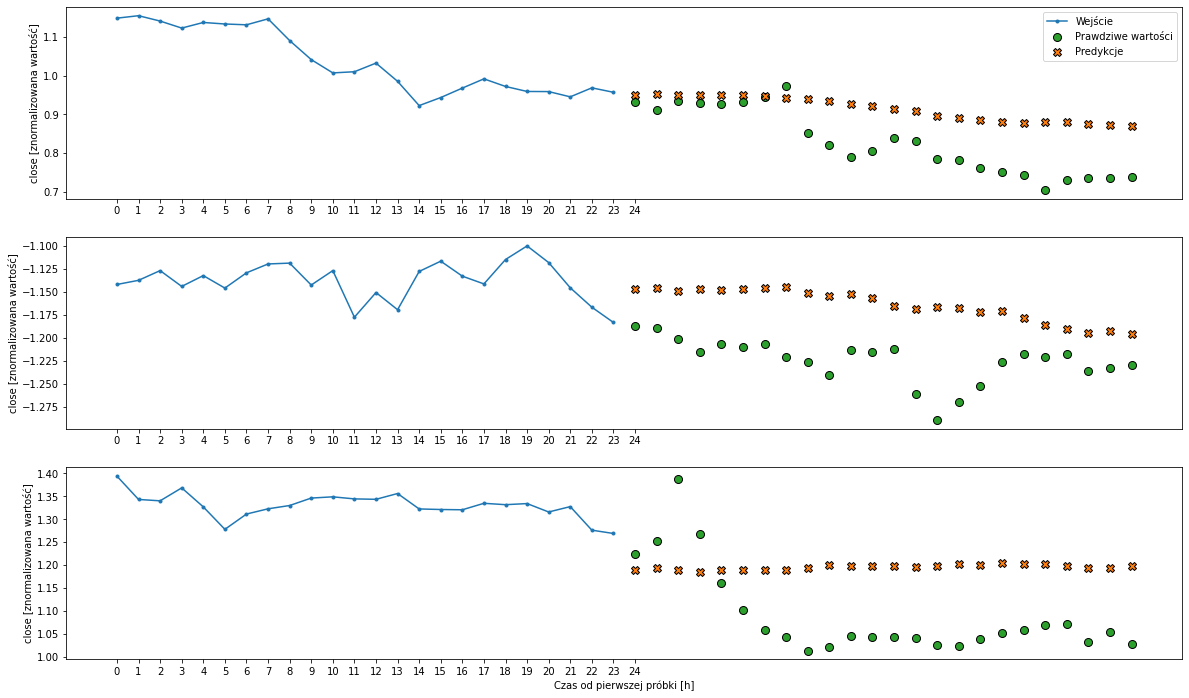

In [91]:
multi_gru_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.GRU(24, return_sequences=True),
    tf.keras.layers.GRU(24, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_gru_model, multi_window)

IPython.display.clear_output()

multi_val_performance['GRU'] = multi_gru_model.evaluate(multi_window.val)
multi_performance['GRU'] = multi_gru_model.evaluate(multi_window.train, verbose=0)
multi_window.plot(multi_gru_model)

In [ ]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [ ]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [96]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [97]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 5])

In [98]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)

  # Insert the first prediction
  predictions.append(prediction)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [99]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 5)


38/38 [==============================] - 0s 3ms/step - loss: 0.1955 - mean_absolute_error: 0.3146


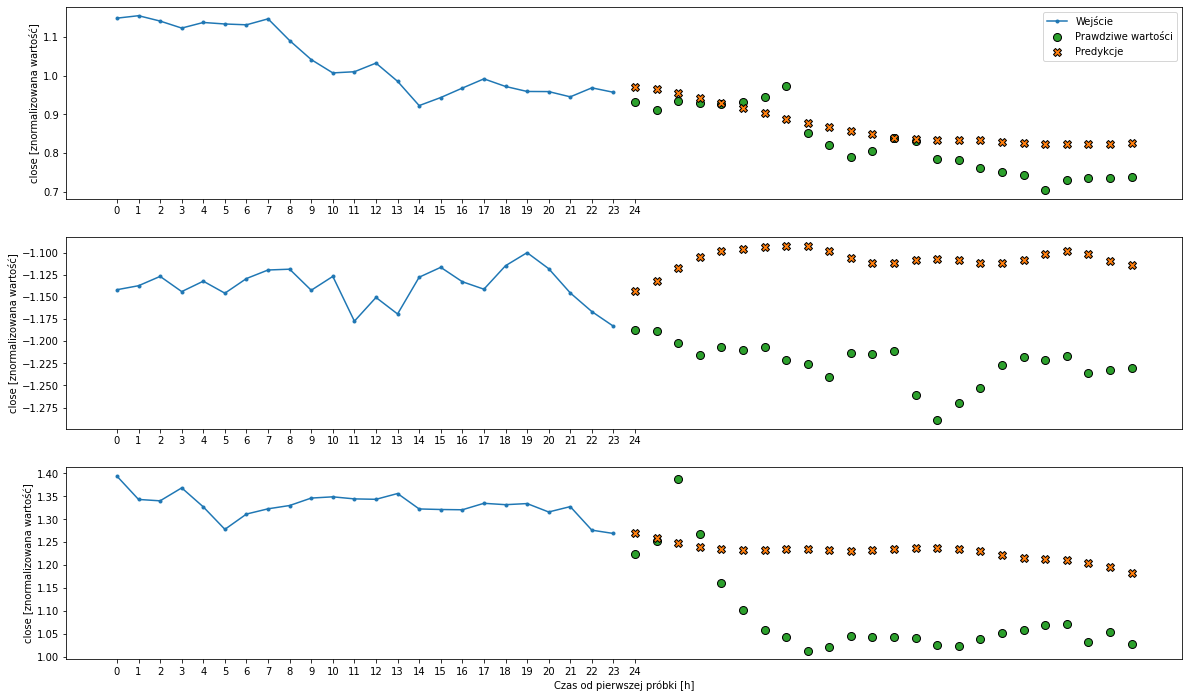

In [100]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

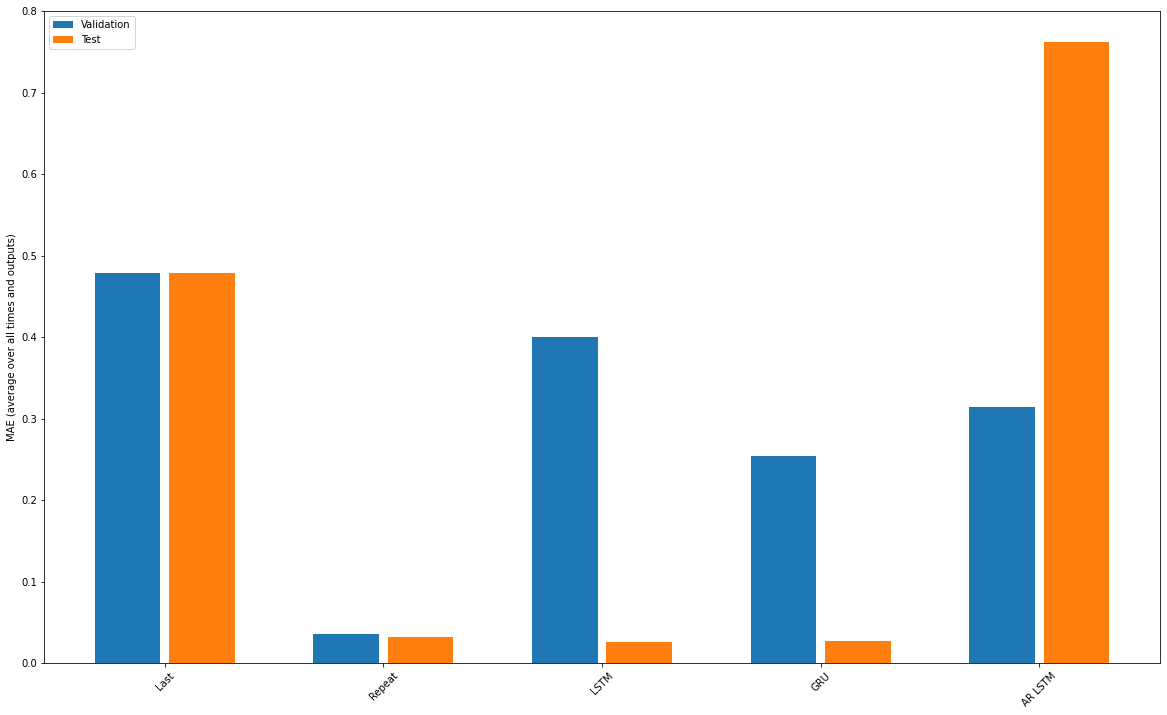

In [102]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [103]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.4792
Repeat  : 0.0322
LSTM    : 0.0266
GRU     : 0.0266
AR LSTM : 0.7622
